In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import matplotlib.pyplot as plt

import numpy as np
import scipy
import tqdm
import torch 
import torch.nn.functional as func

import dataset
import models
import utils

FAUST = "../../Downloads/Mesh-Datasets/MyFaustDataset"
MODEL_PATH = "../model_data/data.pt"

data = dataset.FaustDataset(FAUST)

model = models.ChebClassifier(
    param_conv_layers=[64,64,32,32],
    E_t=data.downscaled_edges, 
    D_t=data.downscale_matrices,
    num_classes = 10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

In [2]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()


now that we have defined the visualization procedure, we can show some meshes:

In [ ]:
import mesh.transforms as mo

x = data[0].pos.clone()
f = data[0].face.t().clone()
mo.transform_rotation_(x, dims=[1,2,0])
visualize(x,f)

## Mean Curvature computation

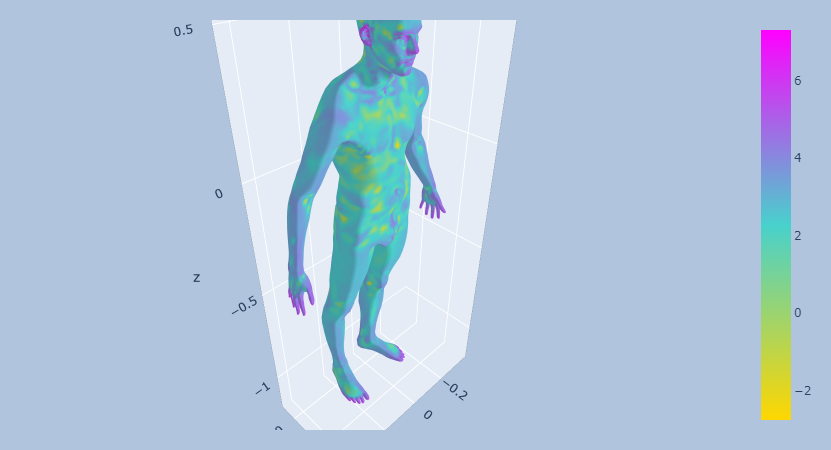

In [3]:
import utils
from mesh.laplacian import laplacebeltrami_FEM
from mesh.laplacian import LB_v2
import torch_sparse as  tsparse

pos = data[0].pos
faces = data[0].face.t()
stiff, area = LB_v2(pos, faces)
n = pos.shape[0]

#eigvals, eigvecs = utils.eigenpairs(pos, faces)
tmp = tsparse.spmm(*stiff, n, n, pos)
ai, av = area
mcn = tsparse.spmm(ai, torch.reciprocal(av), n, n, tmp)
mc = np.linalg.norm(mcn, axis=-1)
np.save("tmp",[pos,faces,mc])

visualize(pos, faces, intensity=np.log(mc))

In [ ]:
x,y,z = pos[:,0],pos[1,:],pos[:,2]


## Metrics


In [ ]:
def compute_distance_mse(pos, perturbed_pos, faces, K, t):
    eigvals1, eigvecs1 = eigenpairs(pos, faces, K)
    eigvals2, eigvecs2 = eigenpairs(perturbed_pos, faces, K)
    d1 = diffusion_distance(eigvals1,eigvecs1,t)
    d2 = diffusion_distance(eigvals2,eigvecs2,t)
    return d1,d2


def compute_distance_distance(distance, perbed_pos, faces, K, t):
    eigvals, eigvecs = eigenpairs(perbed_pos, faces, K)
    d = diffusion_distance(eigvals,eigvecs,t)
    return torch.nn.functional.mse_loss(distance, d)

def get_generator_data(adv_data, faces, K=10, t=0.01):
    out_dictionary = {"MSE_diffusion":[], "LB_loss":[], "MCF_loss":[], "Euclidean_loss":[]}
    diff_distances, mesh_eigenpairs = {}, {}
    for (idx, target), data in adv_data.items():
        print("processing ", idx,":",target)

        # get useful properties
        metrics = data["tracking-data"]
        pos = torch.tensor(data["positions"],dtype=torch.double)
        ppos = torch.tensor(data["perturbed-positions"],dtype=torch.double)
        c = data["c-value"]
        
        if idx not in mesh_eigenpairs:
            mesh_eigenpairs[idx] = utils.eigenpairs(pos, faces, K)
            
        if idx not in diff_distances:
            diff_distances[idx] = diffusion_distance(*mesh_eigenpairs[idx], t)

        out_dictionary["MSE_diffusion"] = compute_distance_distance(
            diff_distances[idx], ppos, faces, K, t)
        
        # insert metrics into output dictionary  
        for k in out_dictionary.keys():
            if k in metrics: out_dictionary[k].append(metrics[k][-1])

    # convert into numpy arrays
    for k in out_dictionary.keys():out_dictionary[k] = np.array(out_dictionary[k])
    return out_dictionary


root = "../model_data/adv_data"
filenames = ["Spectral", "MCF", "Dist"]
faces = data[0].face.t()

generators_data = {}
for fname in filenames:
  absname = os.path.join(root, fname+"AdversarialGenerator.pt")
  with open(absname, "rb") as f:
    generators_data[fname] = pickle.load(f)
    
processed_data = {}
for gname, adv_data in generators_data.items():
    print(gname)
    processed_data[gname] = get_generator_data(adv_data, faces, K=30, t=0.01)
    

## Plot data

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

def boxplot(boxdata, labels=[], title="", ylabel="", xlabel="",savefile=None, yscale=None):
    fig = plt.figure(1, figsize=(9, 6))
    ax = plt.subplot(111)
    ax.boxplot(boxdata)
    if yscale is not None: plt.yscale(yscale)
    locs, _ = plt.xticks()
    plt.xticks(locs, labels,fontsize=17)
    plt.xlabel(xlabel,fontsize=20, fontweight='bold')
    plt.ylabel(ylabel,fontsize=20, fontweight='bold')
    plt.suptitle(title,fontsize=25, fontweight='bold')
    if savefile is not None:
        plt.savefig(savefile,dpi=300,bbox_inches='tight')


In [ ]:
def prefix2label(gen_prefix:str):
    pref2lab = {
         "Spectral":"Laplace-\nBeltrami",
         "Dist":"locally\nEuclidean", 
         "Euclidean":"point-wise\nEuclidean", 
         "MCF":"mean\ncurvature"}
    return pref2lab[gen_prefix]

def generate_diffusion_distance_boxplots(root, names_prefixes, ti, yscale="linear"):
    diffusion_data = {}
    for fname in names_prefixes:
      absname = os.path.join(root, fname+"_diff_dist.pt")
      with open(absname, "rb") as f:
        diffusion_data[fname] = pickle.load(f)
    
    boxdata = np.stack([diffusion_data[name][:,ti] for name in names_prefixes], axis=1)
    labels = [prefix2label(prefix) for prefix in names_prefixes]
    xlab = "Distortion Functions"
    ylab = "Diffusion distance mse"
    title = "Diffusion Distance MSE"
    savefile = "../../Dropbox/LaTeX/master-thesis/img/diff_dist_{}.png".format(ti)
    boxplot(boxdata, labels, title, ylab, xlab, savefile, yscale=yscale)

In [ ]:
root = "../model_data/diff_dist"
filenames = ["Spectral", "MCF", "Dist", "Euclidean"]
generate_diffusion_distance_boxplots(root, filenames, ti=2, yscale="log")


In [ ]:
diffusion_data = {}
for fname in filenames:
  absname = os.path.join(root, fname+"_diff_dist.pt")
  with open(absname, "rb") as f:
    diffusion_data[fname] = pickle.load(f)

boxplot(diffusion_data["Euclidean"][1])

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from mesh.laplacian import LB_v2


def compute_euclidean(pos, perturbed_pos, a):
    z=torch.norm(pos-perturbed_pos, p=2, dim=-1)
    return (z*a).sum(;

def euclidean_statistics(adv_data):
    out = []
    areas={}
    for (idx, target), data in adv_data.items():
        print("processing ", idx,":",target)
        pos = torch.tensor(data["positions"],dtype=torch.double)
        ppos = torch.tensor(data["perturbed-positions"],dtype=torch.double)
        
        if idx not in areas:
            _, (_, a) = LB_v2(pos, faces)
            areas[idx] = a

        out.append(compute_euclidean(pos,ppos, a).numpy())
    return  np.array(out)

root = "../model_data/adv_data"
filenames = ["Spectral", "MCF", "Dist", "Euclidean"]
faces = data[0].face.t()

generators_data = {}
for fname in filenames:
  absname = os.path.join(root, fname+"AdversarialGenerator.pt")
  with open(absname, "rb") as f:
    generators_data[fname] = pickle.load(f)
    
processed_data = {}
for gname, adv_data in generators_data.items():
    print(gname)
    processed_data[gname] = euclidean_statistics(adv_data)
    

In [ ]:
boxdata = [processed_data["Spectral"],  processed_data["Dist"], processed_data["Euclidean"],processed_data["MCF"]]
labels = ["Laplace-\nBeltrami","locally\nEuclidean", "point-wise\nEuclidean", "mean\ncurvature"]
xlab = "Distortion Functions"
ylab = "Euclidean error"
title = "Euclidean Error"
savefile = "../../Dropbox/LaTeX/master-thesis/img/euclidean.png"
boxplot(boxdata, labels,title, ylab,xlab,savefile)

In [ ]:
root = "../model_data/"
savefile = "../../Dropbox/LaTeX/master-thesis/img/gerror.png"
filenames = ["Spectral", "MCF", "Dist", "Euclidean"]

gerror =scipy.io.loadmat(root+"geodesic_error", struct_as_record=False)["geodesic_error_struct"][0,0]
L = np.concatenate([getattr(gerror, attr) for attr in filenames], axis=1)

labels = [prefix2label(prefix) for prefix in filenames]
boxplot(
    boxdata = L/(6890**2),
    labels = labels,
    title = "Geodesic Error",
    ylabel = "mean geodesic error",
    xlabel = "Distortion Functions",
    savefile=savefile)



# Other

In [98]:
pos = data[0].pos
faces = data[0].face.t()
t = 0.1
eigvals,eigvecs = utils.eigenpairs(pos,faces,K=300)
hk = utils.heat_kernel(eigvals,eigvecs,t)
d = utils.diffusion_distance(eigvals,eigvecs,t)

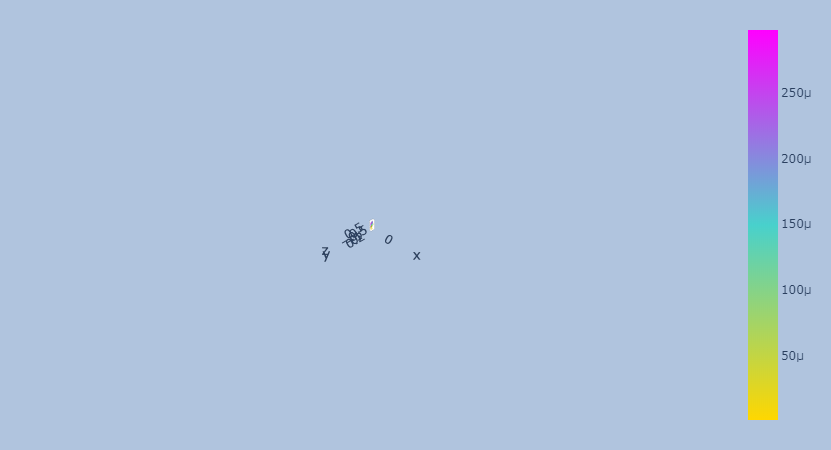

In [99]:
vi = 3000
lb,ub =-1e-6,1e-4
p = hk[vi,:]/hk[vi,:].sum()
c = (p<=ub)*(p>=lb)
visualize(pos, faces, p)

In [109]:
from mesh.laplacian import LB_v2
_, (_,a) = LB_v2(pos, faces)
print((hk[6000,:]*a).sum())

tensor(1.0000)
